# Composition based on Centones in Arab-Andalusian Music

Notebook that looks for characteristic centones of the 26 tubu's of the Arab Andalusian Music in a score. Then, show the results to link the number of found centones with the correspondance main tab' of the score.

In [1]:
from music21 import *
from compmusic import dunya
import os
import re
import copy
import csv
import json
import pandas as pd
from pathlib import Path
from operator import itemgetter
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
dunya.set_token('52fc6ac49c0b7fc9644404aaf4f9bc1a7088d69d')

apipath = 'api/andalusian/recording/'

## Step 1: Load CSV
Download the metadata and the score of each recording, to have the .musicxml file and the annotated tab'.

In [2]:
def load_and_parse_centones_mapping(mapping_path):
    """
    Load csv of centone mapping to dict
    """
    centones = pd.read_csv(mapping_path, header=None)
    return {'Nawba_{}'.format(x[0]):[y.replace(' ','') for y in list(x[1:]) if str(y) != 'nan'] \
            for i, x in centones.iterrows()}

In [3]:
# Nawba Mappings
nawba_centones = load_and_parse_centones_mapping('data/Centones_Nawba.csv')

with open('data/nawba_tabs.json', 'r') as fp:
    nawba_tabs = json.load(fp)
    
tabs_nawba = {}
for k,v in nawba_tabs.items():
    for t in v:
        tabs_nawba[t] = k
        
# Recording Description
andalusian_description =  pd.read_json('data/andalusian_description.json')

# Step 2: Download scores

In [4]:
scores = []
for i, row in andalusian_description.iterrows():
    try:
        tn = row['sections'][0]['tab']['transliterated_name']
    except:
        tn = ''
    scores.append([row['mbid'], tn])


Download the required scores from Dunya through the cell below:

In [161]:
if not os.isdir('Scores'):
    os.mkdir('Scores')

bad_mbid = []
for s in scores: # Download scores from dunya through its mbid
    mbid = s[0]
    try:
        score_xml = dunya.docserver.file_for_document(mbid, 'symbtrxml')
        name = mbid + '.xml'
        path = os.path.join('Scores', name)
        open(path, "wb").write(score_xml)
    except: 
        bad_mbid.append(mbid)

scores = [x for x in scores if x[0] not in bad_mbid]

In [5]:
# Replace tab with nawba
scores_nawba = [[x[0], tabs_nawba[x[1]]] for x in scores if x[1] in tabs_nawba]

# Lookup
nawba_lookup = {x[0]:x[1] for x in scores_nawba}

Load a csv file that contains all the characteristic centones for each tab' and the final centones for each tab and store it in a dictionary (data and data_final)

## Step 2: Searching general centones
For each score in the dataset, look for the characteristic centones of each tab' and store the results in a final dataframe. In this dataframe will be stored a coefficient and the name of the 10 most likely tubu's related with this coefficient. This coefficient is the normalization of the occurrances of the centones for each tab' in the recording. (Running next cell might can take around 10 minutes)

In [16]:
def count_letters(x): # This function will be used to count the length of each centon.
        counter = 0
        for let in x:
            if let!='-' and let!='#':
                counter+=1
        return counter
    
def count_centones(fn):
    path = 'Scores/'
    s = converter.parse(fn)
    p = s.parts[0]
    notes = p.flat.notes.stream() # These are all the notes of the whole piece
    if not any(x.isChord == True for x in notes):
        # Count centones:
        total_results = []
        for d in nawba_centones: # For each tab' we count the number of centones
            ncentones = []
            for centon in nawba_centones[d]: # count the number of apperances of every centon in the set of centones of the tab'
                clen = count_letters(centon)
                numbercentones = 0
                for i in range(len(notes[:-clen+1])): # Check all the combinations depending on the number of notes of the
                    buffer = []                       # centon and if matches-> numbercentones+=1
                    for j in range(clen):
                        buffer.append(notes[i+j])
                    phrase = ''
                    for n in buffer:   
                            phrase += n.name
                    if phrase == centon:
                        numbercentones += 1
                ncentones.append(numbercentones) # Acumulate the number of every kind of centones in a list
            total_results.append([d, sum(ncentones)]) # Store in a list of tuples [(name of tab', appearances of characteristics centones)]
            number_centones_nawba[d] = len(nawba_centones[d])

        total_results_coef = [[x[0],x[1]/number_centones_nawba[x[0]]] for x in total_results]
        results_to_df = sorted(total_results_coef, key=itemgetter(1))
        results_to_df = results_to_df[::-1]
    return results_to_df[0]
    

df = []
number_centones_nawba={}
for mbid in tqdm(nawba_lookup): 
    fileName = mbid + '.xml'
    fn = os.path.join(path, fileName)
    fn = Path(fn)
    nawba = nawba_lookup[mbid]
    predicted_nawba = count_centones(fn)
    df.append({'Mbid':mbid, 'Annotated_tab': nawba,'1 tab': predicted_nawba})

100%|██████████| 150/150 [38:25<00:00, 24.56s/it]


The computed data can be visualized in the next dataframe

In [21]:
df_centones= pd.DataFrame(df)
df_centones= df_centones[['Mbid','Annotated_tab','1 tab']]
#df_centones.to_pickle('nawba_results')

The cell below review the computed datas in percentages

The tab with the most number of characteristics centones and the annotations matched in:  22.14765100671141 %


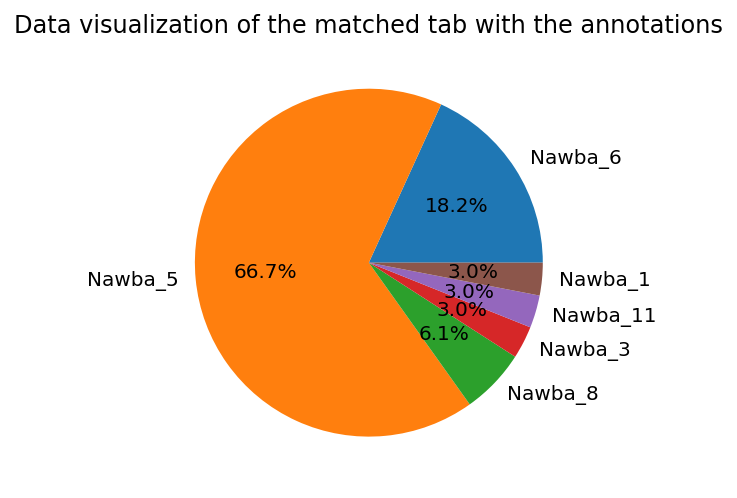

In [18]:
cont=0
tab_work=[]
for index, row in df_centones.iterrows():
    if row['Annotated_tab']==row['1 tab'][0]:
        tab_work.append(row['Annotated_tab'])
        cont += 1
print('The tab with the most number of characteristics centones and the annotations matched in: ',cont*100/(df_centones.shape[0]),'%')
    
values = Counter(tab_work).values()
keys = Counter(tab_work).keys()
plt.pie([v for v in values], labels=[k for k in keys],autopct='%.1f%%')
plt.title('Data visualization of the matched tab with the annotations')
plt.show()

Confusion matrix, without normalization


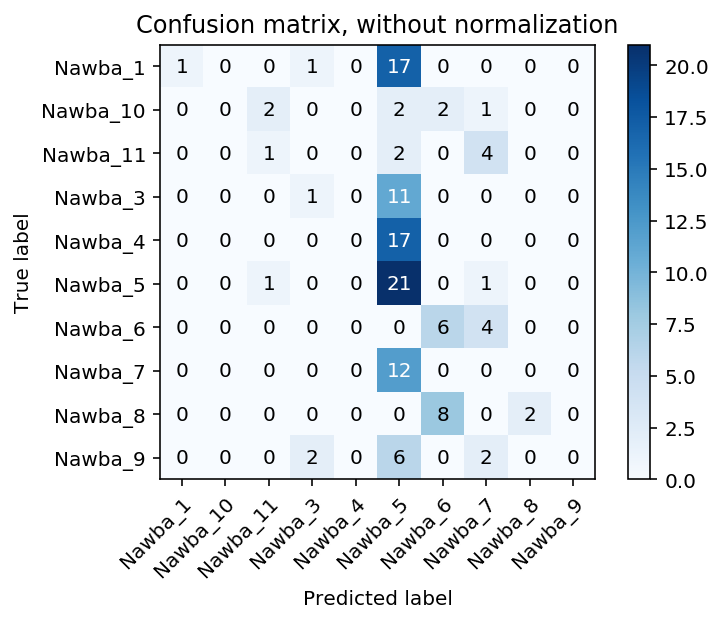

In [223]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

annotated = df_centones['Annotated_tab'].tolist()
predicted = df_centones['1 tab'].tolist()
predicted = [x[0] for x in predicted]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(annotated, predicted, classes=classes,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(annotated, predicted, classes=classes, normalize=True,
                      #title='Normalized confusion matrix')

plt.show()